# Background Subtraction in the Stack
<br>Owner(s): **Imran Hasan** ([@ih64](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@username1)), **Second Owner** ([@username2](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@username2))
<br>Last Verified to Run: **20XX-XX-XX**
<br>Verified Stack Release: **16.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Do this thing;
2. Do this other thing;
3. Understand this concept;
4. Produce your own etc etc.

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

The next few cells give you some options for your "Set-up" section - you may not need them all.

We'll need the `stackclub` package to be installed. If you are not developing this package, you can install it using `pip`, like this:
```
pip install git+git://github.com/LSSTScienceCollaborations/StackClub.git#egg=stackclub
```
If you are developing the `stackclub` package (eg by adding modules to it to support the Stack Club tutorial that you are writing, you'll need to make a local, editable installation. In the top level folder of the `StackClub` repo, do:

In [1]:
! cd .. && python setup.py -q develop --user && cd -

/home/ishasan/lsst/StackClub/SkyBackground


When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [2]:
%load_ext autoreload
%autoreload 2

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [3]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jld-lab-ishasan-r160
lsst_distrib          16.0+1     	current v16_0 setup


For this tutorial we'll need the following modules:

In [4]:
%matplotlib inline
#%matplotlib ipympl

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown

In [5]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase

import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom

import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable

import lsst.afw.display as afwDisplay

from lsst.meas.algorithms import SubtractBackgroundTask, SubtractBackgroundConfig

/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/meas_mosaic/16.0+1/python/lsst/meas/mosaic/utils.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/traitlets/config/application.py

In [6]:
%matplotlib inline
plt.style.use('seaborn-poster')

## Section Title

Background estimation and source detection are closely linked together, and in tasks like processCcd, they are run iteratively ...

We will follow along ADW's Low Surface Brightness notebook to provide familiarity to users who have been introduced to source detection with his working examples ...

In [7]:
# The dafPersist was trying to set the matplotlib backend, catch warning
datadir = "/project/shared/data/Twinkles_subset/output_data_v2"
butler = dafPersist.Butler(datadir)
dataId = {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 235}
#Unset all bits of the mask plane
calexp = butler.get('calexp', **dataId)
calexp.mask.clearAllMaskPlanes()

In [8]:
#the background that has been subtracted off wasn't persisted, I'll have to figure out a work around
#merlin gave a helpful suggestion that I reprocess a ccd by hand and persist the bg model

#subed_bg = butler.get(calexpBackground, dataId)
#calexp += subed_bg

In [9]:
# Importing the tasks
from lsst.meas.algorithms.detection    import SourceDetectionTask

In [10]:
# Create the Tasks
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10       # detection threshold in units of thresholdType
config.thresholdType = "stdev"   # units for thresholdValue

sourceDetectionTask =   SourceDetectionTask(schema=schema, config=config)

In [11]:
bg_config = SubtractBackgroundTask.ConfigClass()
bg_config.statisticsProperty = 'MEAN'
bg_task = SubtractBackgroundTask(config=bg_config)
#bg_task.statisticsProperty='MEAN'

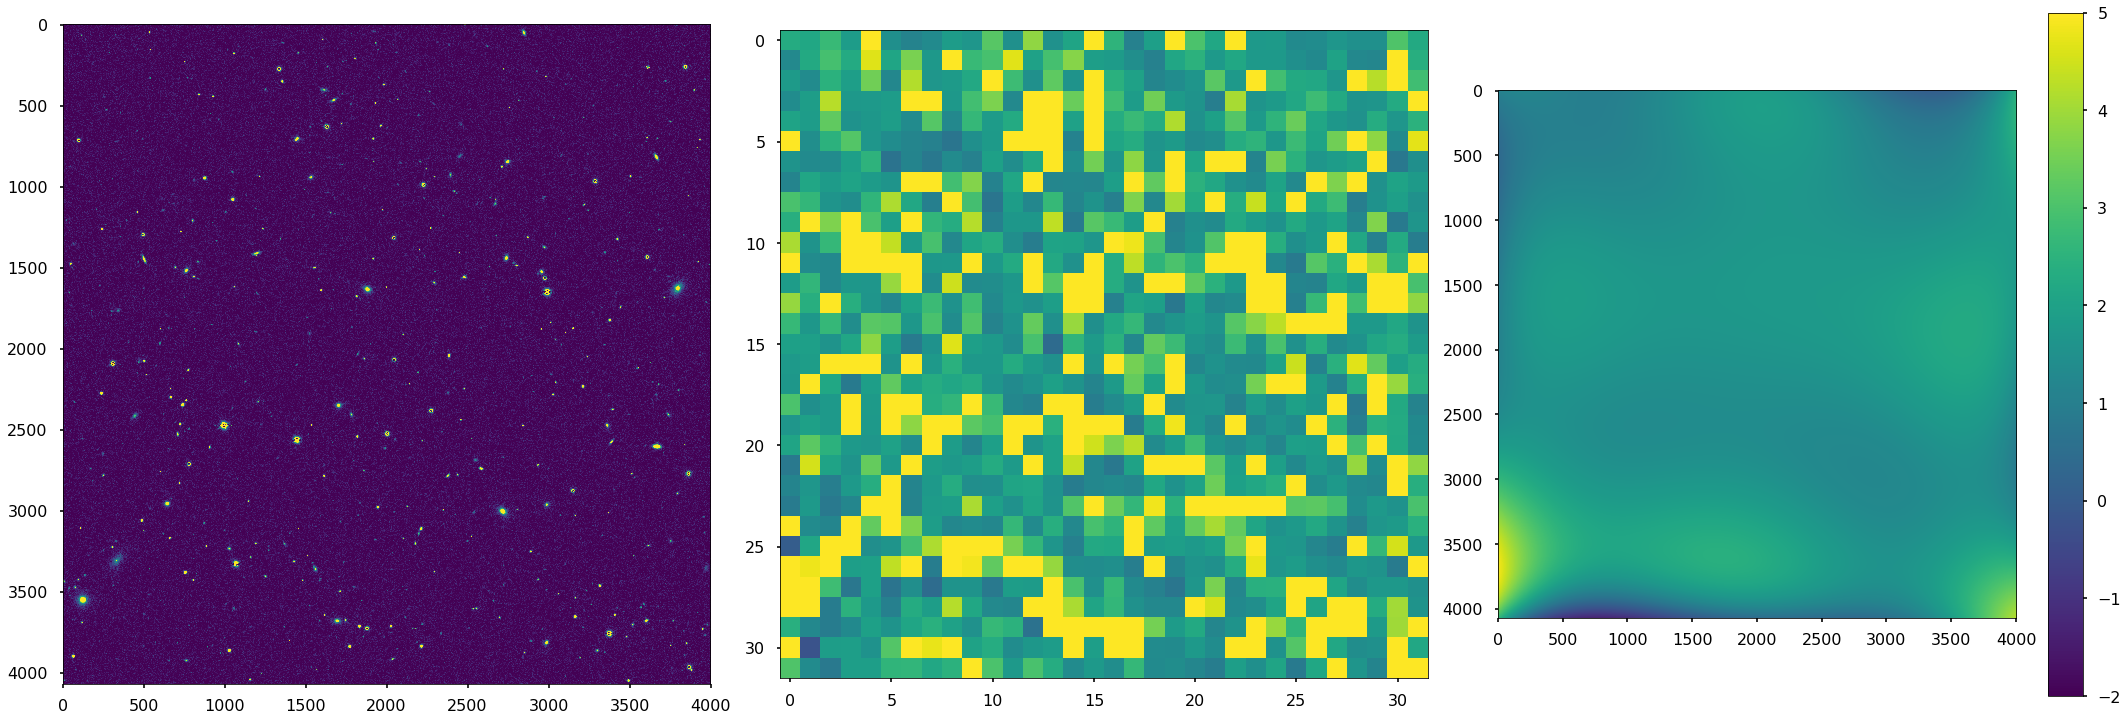

In [12]:
bg = bg_task.fitBackground(calexp.getMaskedImage(), nx=32, ny=32)

mean, mask, var = bg.getStatsImage().getArrays()

f, ax = plt.subplots(ncols=3, nrows=1, figsize=(30,10))
ax[0].imshow(calexp.getImage().getArray(), vmin=0, vmax=500)
ax[1].imshow(mean, vmin=-5, vmax=5)
bg = ax[2].imshow(bg.getImageF().getArray(), vmin=-2, vmax=5)
plt.colorbar(bg, ax=ax[2])
plt.tight_layout()

In [13]:
calexp.getImage().getArray()[:127,:125].mean()

1.1410258

In [14]:
mean[0,0]

1.1410258

In [15]:
tab = afwTable.SourceTable.make(schema)
result = sourceDetectionTask.run(tab, calexp)

In [16]:
calexp.getMask().getArray().mean()

1.059041257367387

In [17]:
# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib') 
# ADW: why can't we set the backend before this cell?

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage())

plt.gca().axis('off')

(-0.5, 3999.5, -0.5, 4071.5)

<Figure size 921.6x633.6 with 0 Axes>

In [18]:
bg = bg_task.fitBackground(calexp.getMaskedImage(), nx=32, ny=32)

mean, mask, var = bg.getStatsImage().getArrays()

f, ax = plt.subplots(ncols=3, nrows=1, figsize=(30,10))
ax[0].imshow(calexp.getImage().getArray(), vmin=0, vmax=500)
ax[1].imshow(mean, vmin=-5, vmax=5)
bg = ax[2].imshow(bg.getImageF().getArray())
plt.colorbar(bg, ax=ax[2])
plt.tight_layout()


In [19]:
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 3       # detection threshold in units of thresholdType
config.thresholdType = "stdev"   # units for thresholdValue

sourceDetectionTask =   SourceDetectionTask(schema=schema, config=config)

In [20]:
tab = afwTable.SourceTable.make(schema)
result = sourceDetectionTask.run(tab, calexp)

In [21]:
# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib') 
# ADW: why can't we set the backend before this cell?

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage())

plt.gca().axis('off')

(-0.5, 3999.5, -0.5, 4071.5)

<Figure size 921.6x633.6 with 0 Axes>

In [22]:
bg = bg_task.fitBackground(calexp.getMaskedImage(), nx=32, ny=32)

mean, mask, var = bg.getStatsImage().getArrays()

f, ax = plt.subplots(ncols=3, nrows=1, figsize=(30,10))
ax[0].imshow(calexp.getImage().getArray(), vmin=0, vmax=500)
ax[1].imshow(mean, vmin=-5, vmax=5)
bg = ax[2].imshow(bg.getImageF().getArray())
plt.colorbar(bg, ax=ax[2])
plt.tight_layout()

In [23]:
bg.getImageF().getArray().min()

AttributeError: 'AxesImage' object has no attribute 'getImageF'

In [ ]:
plt.style.use('seaborn-poster')

In [ ]:
calexp = butler.get('calexp', **dataId)
# Unset the `DETECTED` bits of the mask plane
bg = bg_task.run(calexp)
plt.imshow(bg.background.getImage().getArray())
plt.colorbar()

## Summary

Remind the user what they have done, and what they should now be able to do.

You could also point them to a related tutorial or reference source, to help them go further.